<a href="https://colab.research.google.com/github/DH-davidhuang/Generative-Adversarial-182-Networks-Research/blob/main/Finetuning_Pre_Trained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install git+https://github.com/lukemelas/pytorch-pretrained-gans
!pip install --upgrade jax jaxlib
!pip install tensorflow tensorflow-datasets
!pip install torch
from PIL import Image


  Cloning https://github.com/lukemelas/pytorch-pretrained-gans to /tmp/pip-req-build-soc9uohm
  Running command git clone --filter=blob:none --quiet https://github.com/lukemelas/pytorch-pretrained-gans /tmp/pip-req-build-soc9uohm
  Resolved https://github.com/lukemelas/pytorch-pretrained-gans to commit 2982fdab4e683165e45bc2f4a64c2942a7a3a1b7
  Preparing metadata (setup.py) ... done


In [7]:
!pip install boto3

Loading BigGAN model biggan-deep-256 from cache at /root/.pytorch_pretrained_biggan/e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43


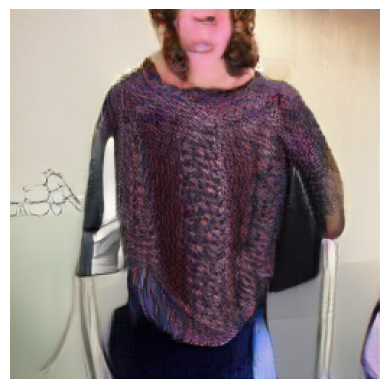

In [8]:
# Code to sample a random image

import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from pytorch_pretrained_gans import make_gan

# Sample a class-conditional image from BigGAN with default resolution 256
G = make_gan(gan_type='biggan')  # This is an assumed function
y = G.sample_class(batch_size=1)  # Sample class
z = G.sample_latent(batch_size=1)  # Sample latent vector
x = G(z=z, y=y)  # Generate image

# Process the image for display
x = (x + 1) / 2  # Rescale to [0, 1]
x = x.clamp(0, 1)
to_pil_image = ToPILImage()
image = to_pil_image(x.squeeze(0))  # Convert to PIL Image

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()


Leveraging Pre-Trained BigGan model to create anime images via fine-tuning

In [9]:
! pip install -q kaggle
from google.colab import files

# Create the .kaggle directory
!mkdir ~/.kaggle

# Move the kaggle.json file into this directory
!mv kaggle.json ~/.kaggle/

# Change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


36740
(64, 64, 64, 3)


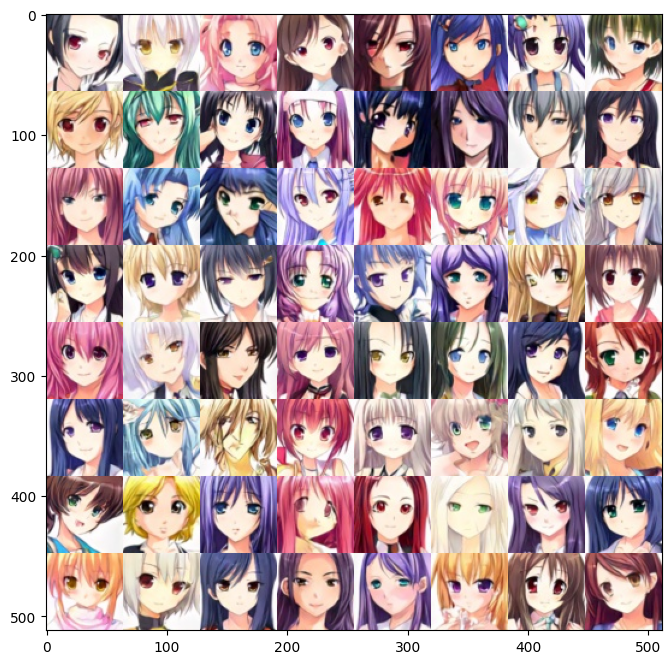

In [10]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import kaggle
import glob
import random

%matplotlib inline
# Function to show images
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

# Function to download data from Kaggle
def download_data():
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('lunarwhite/anime-face-dataset-ntumlds', path='./', unzip=True)

# Call the function to download the data
download_data()

root = './faces/images/'
from PIL import Image
import glob
image_list = []
rows = []
for filename in glob.glob('./images/*.jpg'):
    im=Image.open(filename)
    rows.append([filename])
    image_list.append(filename)

print(len(image_list))
def gallery(array, ncols=8):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

from PIL import Image
import random
def make_array():

    arr = []
    # Randomly select 64 images to visualize
    for i in range(64):
        random_image = random.choice(image_list)
        arr.append(np.asarray(Image.open(random_image).convert('RGB')))
    print(np.array(arr).shape)
    return np.array(arr)

array = make_array()
result = gallery(array)
plt.figure(figsize=(8,8))
plt.imshow(result)
plt.show()


In [11]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to 256x256
    transforms.ToTensor(),  # Convert the image to a PyTorch Tensor
    # Normalize with ImageNet mean and std if necessary
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def make_array():
    arr = []
    for i in range(64):
        random_image = random.choice(image_list)
        image = Image.open(random_image).convert('RGB')
        image = transform(image)  # Apply transformations here
        arr.append(np.asarray(image))
    print(np.array(arr).shape)
    return np.array(arr)

# Rest of your code remains the same


In [12]:
import pandas as pd
df = pd.DataFrame(rows)
df.to_csv('data.csv', index=False, header = None)

In [21]:
#The batch_size is defined by yourself based on the memory of GPU or CPU.
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

class AnimeData(Dataset):
    """
    Wrap the data into a Dataset class, and then pass it to the DataLoader
    :__init__: Initialization data
    :__getitem__: support the indexing such that dataset[i] can be used to get ith sample
    :__len__: return the size of the dataset.
    """
    def __init__(self, root, transform=None):
        self.frame = pd.read_csv(root, header=None)
        self.transform = transform


    def __len__(self):
        return len(self.frame)


    def __getitem__(self, index):
        image_name = self.frame.iloc[index, 0]
        image = Image.open(image_name)
        image = self.transform(image)
        return image
# Define your dataset and transform
trainset = AnimeData(root='./data.csv', transform=transform)

# Specify the batch size (you might have defined it earlier)
batch_size = 64

# Set the device for the data loader
device = 'cuda:0'  # or 'cpu' if you want to use CPU

# Create the DataLoader with the specified device
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Move the data loader to the specified device
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)



In [14]:
import torch
import torch.nn as nn
from pytorch_pretrained_gans import make_gan

class GeneratorWrapper(nn.Module):
    """ A wrapper to put the GAN in a standard format."""

    def __init__(self, G, num_classes=None):
        super().__init__()
        self.G = G
        self.dim_z = G.dim_z
        self.conditional = True if num_classes is not None else False

    def forward(self, z, y=None):
        if self.conditional and y is not None:
            x = self.G(z, y)
        else:
            x = self.G(z)
        return x

    def sample_latent(self, batch_size, device='cpu'):
        z = torch.randn(batch_size, self.dim_z, device=device)
        return z

    def sample_class(self, batch_size, device='cpu'):
        assert self.conditional, "GAN is not conditional"
        y = torch.randint(0, self.G.num_classes, (batch_size,), device=device)
        return y


In [15]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

In [16]:
# Create your Discriminator and load the pre-trained BigGAN
G = make_gan(gan_type='biggan').to(device)  # Move BigGAN to the device


Loading BigGAN model biggan-deep-256 from cache at /root/.pytorch_pretrained_biggan/e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43


In [17]:
# Freeze all layers except the last one in BigGAN's generator
for name, param in G.G.generator.named_parameters():
    if name != 'conv_to_rgb.weight' and name != 'conv_to_rgb.bias':
        param.requires_grad = False
    else:
        param.requires_grad = True


In [18]:
#TODO: Create your Discriminator model
class Discriminator(nn.Module):
    def __init__(self,inchannels):
        super(Discriminator,self).__init__()
        """
        Initialize the Discriminator Module
        :param inchannels: The depth of the first convolutional layer
        """
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=0),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: Discriminator logits; the output of the neural network
        """
        x = self.conv_block1(x)
        return x

D=Discriminator(3).to(device)



In [28]:

# Ensure that the model (D and G) is on the same device as well
D = D.to(device)
G = G.to(device)


In [33]:
import torch

def check_device_placement(model, device):
    # Iterate through all model parameters and modules
    for name, param in model.named_parameters():
        if not param.is_cuda and device != 'cpu':
            # If a parameter is on CPU but should be on GPU
            print(f"Moving parameter '{name}' to device '{device}'")
            param.data = param.data.to(device)

    # Recursively check device placement of modules
    for name, module in model.named_children():
        check_device_placement(module, device)

# Example usage:
device = 'cuda:0'   # Replace with your desired device

# Ensure consistent device placement for the entire model
G.to(device)

# Check and fix device placement for model parameters and modules
check_device_placement(G, device)


In [34]:
import torch

def check_device_placement(model, device):
    # Iterate through all model parameters and modules
    for name, param in model.named_parameters():
        if not param.is_cuda and device != 'cpu':
            # If a parameter is on CPU but should be on GPU
            print(f"Moving parameter '{name}' to device '{device}'")
            param.data = param.data.to(device)

    # Recursively check device placement of modules
    for name, module in model.named_children():
        check_device_placement(module, device)

# Example usage:
device = 'cuda:0'   # Replace with your desired device

# Ensure consistent device placement for the entire model
D.to(device)

# Check and fix device placement for model parameters and modules
check_device_placement(D, device)


In [43]:
import torch
from pytorch_pretrained_gans import make_gan

# Sample a class-conditional image from BigGAN with default resolution 256
G = make_gan(gan_type='biggan')  # -> nn.Module
z = G.sample_latent(batch_size=1)  # -> torch.Size([1, 128])
x = G(z=z)  # -> torch.Size([1, 3, 256, 256])

Loading BigGAN model biggan-deep-256 from cache at /root/.pytorch_pretrained_biggan/e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43


In [46]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
device = 'cuda:0'  # or 'cpu' if you want to use CPU

# Define custom loss functions
loss_fn = torch.nn.MSELoss().to(device)
device = 'cuda:0'  # or 'cpu' if you want to use CPU

def Real_loss(preds, targets):
    '''
       Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss
    '''
    beta_distr = torch.distributions.beta.Beta(1, 5, validate_args=None)
    label_noise = beta_distr.sample(sample_shape=targets.shape).to(device)
    loss = loss_fn(targets, preds - label_noise)
    return loss

def Fake_loss(preds, targets):
    '''
       Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss
    '''
    beta_distr = torch.distributions.beta.Beta(1, 5, validate_args=None)
    label_noise = beta_distr.sample(sample_shape=targets.shape).to(device)
    loss = loss_fn(targets, preds + label_noise)
    return loss

# Create your Discriminator and load the pre-trained BigGAN
G = make_gan(gan_type='biggan')  # This will load the pre-trained BigGAN
D = Discriminator(inchannels=3).to(device)

# Define optimizers
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define other training parameters
batch_size = 64
latent_size = 128
epochs = 15

# Complete the training function
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

def train(D, G, d_optimizer, g_optimizer, epochs=1):
    iter_count = 0
    start_idx = 1
    for epoch in range(epochs):
        for real_images in tqdm(trainloader):
            real_images = real_images.to(device)
            # Pass real images through discriminator
            D_out_real = D(real_images)
            # Check if the trainloader is sending data to the correct device (CPU or GPU)
            print("Device of real_images:", real_images.device)

            label_real = torch.full(D_out_real.shape, 1.0).to(device)
            real_loss = Real_loss(label_real, D_out_real)
            real_score = torch.mean(D_out_real).item()

            # Generate fake images

            z = G.sample_latent(batch_size=1)  # -> torch.Size([1, 128])
            fake_images = G(z=z).to(device) # -> torch.Size([1, 3, 256, 256])
            # Pass fake images through discriminator
            D_out_fake = D(fake_images)
            label_fake = torch.full(D_out_fake.shape, 0).to(device)
            fake_loss = Fake_loss(label_fake, D_out_fake)
            fake_score = torch.mean(D_out_fake).item()

            # Update discriminator weights
            loss_d = real_loss + fake_loss

            d_optimizer.zero_grad()
            loss_d.backward(retain_graph=True)
            d_optimizer.step()

            # Generate fake images
            z2 = G.sample_latent(batch_size=1)  # -> torch.Size([1, 128])
            fake_images2 = G(z=z2).to(device) # -> torch.Size([1, 3, 256, 256])
            gen_steps = 1
            for i in range(0, gen_steps):
                # Try to fool the discriminator
                D_out_fake2 = D(fake_images2)

                # The label is set to 1 (real-like) to fool the discriminator
                label_real1 = torch.full(D_out_fake2.shape, 1.0).to(device)
                loss_g = Real_loss(label_real1, D_out_fake2)

                # Update generator weights
                g_optimizer.zero_grad()
                loss_g.backward(retain_graph=(i < gen_steps - 1))
                g_optimizer.step()

        losses_g.append(loss_g.item())
        losses_d.append(loss_d.item())
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch + start_idx, fixed_latent, G, show=True)

        state_dis = {'dis_model': D.state_dict(), 'epoch': epoch}
        state_gen = {'gen_model': G.state_dict(), 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state_dis, 'checkpoint/' + 'D__' + str(epoch + 1))  # each epoch
        torch.save(state_gen, 'checkpoint/' + 'G__' + str(epoch + 1))  # each epoch

# Train the GAN
train(D, G, d_optimizer, g_optimizer, epochs=15)

Loading BigGAN model biggan-deep-256 from cache at /root/.pytorch_pretrained_biggan/e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43


  0%|          | 0/575 [00:00<?, ?it/s]

Device of real_images: cuda:0


  0%|          | 1/575 [00:10<1:40:00, 10.45s/it]

Device of real_images: cuda:0


  0%|          | 2/575 [00:20<1:36:22, 10.09s/it]

Device of real_images: cuda:0


  1%|          | 3/575 [00:28<1:28:59,  9.34s/it]

Device of real_images: cuda:0


  1%|          | 4/575 [00:38<1:29:28,  9.40s/it]

Device of real_images: cuda:0


  1%|          | 5/575 [00:46<1:25:27,  9.00s/it]

Device of real_images: cuda:0


  1%|          | 6/575 [00:55<1:24:30,  8.91s/it]

Device of real_images: cuda:0


  1%|          | 7/575 [01:04<1:24:27,  8.92s/it]

Device of real_images: cuda:0


  1%|▏         | 8/575 [01:11<1:20:17,  8.50s/it]

Device of real_images: cuda:0


  2%|▏         | 9/575 [01:23<1:28:28,  9.38s/it]

Device of real_images: cuda:0


  2%|▏         | 10/575 [01:34<1:33:10,  9.90s/it]

Device of real_images: cuda:0


  2%|▏         | 11/575 [01:46<1:38:45, 10.51s/it]

Device of real_images: cuda:0


  2%|▏         | 12/575 [01:58<1:43:45, 11.06s/it]

Device of real_images: cuda:0


  2%|▏         | 12/575 [02:09<1:41:23, 10.80s/it]


KeyboardInterrupt: ignored

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCELoss()  # Binary Cross Entropy Loss
generator = wrapped_generator.G.generator
discriminator = wrapped_generator.discriminator
# Assuming your generator and discriminator are already defined
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
for epoch in range(num_epochs):
    for real_images in anime_dataloader:
        # Train Discriminator
        discriminator.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_images), torch.ones_like(real_images))
        fake_images = generator(sample_noise()).detach()
        fake_loss = criterion(discriminator(fake_images), torch.zeros_like(fake_images))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        generator.zero_grad()
        fake_images = generator(sample_noise())
        g_loss = criterion(discriminator(fake_images), torch.ones_like(fake_images))
        g_loss.backward()
        g_optimizer.step()
